In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import csv
import datetime
import utils

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from keras import models
from keras import optimizers
from keras.layers import Dense, Dropout, Reshape
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
"""
Combined_News_DJIA.csv consist of top 25 daily news
Description:

There are two channels of data provided in this dataset:

News data: I crawled historical news headlines from Reddit WorldNews Channel (/r/worldnews). T
hey are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. 
(Range: 2008-06-08 to 2016-07-01)

Stock data: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

I provided three data files in .csv format:

RedditNews.csv: two columns The first column is the "date", and second column is the "news headlines". 
All news are ranked from top to bottom based on how hot they are. Hence, there are 25 lines for each date.

DJIA_table.csv: Downloaded directly from Yahoo Finance: check out the web page for more info.

Combined_News_DJIA.csv: To make things easier for my students, I provide this combined dataset with 27 columns. 
The first column is "Date", the second is "Label", and the following ones are news headlines ranging from "Top1" to "Top25".
"""

In [2]:
dji_news_df = pd.read_csv('Combined_News_DJIA.csv')
dji_news_df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [0]:
#Making Date as index and removing Label column as we are going to create our own labels
dji_news_df.index = dji_news_df['Date']
dji_news_df = dji_news_df.drop(['Label', 'Date'], axis = 1)

In [0]:
#Combining all top 25 news into a single column seperated by a space
dji_news_df['combined_news'] = dji_news_df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis = 1)
dji_news_df = dji_news_df[['combined_news']]

In [0]:
#Cleaning the text data
dji_news_df['combined_news'] = dji_news_df['combined_news'].apply(utils.normalize_headline)

In [6]:
dji_news_df.head()

,combined_news
Date,
2008-08-08,georgia 'downs two russian warplanes' as count...
2008-08-11,why wont america and nato help us? if they won...
2008-08-12,remember that adorable 9-year-old who sang at ...
2008-08-13,u.s. refuses israel weapons to attack iran: r...
2008-08-14,all the experts admit that we should legalise ...


In [0]:
start = min(dji_news_df.index)
end = max(dji_news_df.index)
stock_df = utils.get_sequential_stock_data(start, end, "GOOG")

In [0]:
#Getting our own labels (stock market trend) to predict
y = utils.get_stock_labels(start, end, "GOOG", 0.5, shift=1)

In [0]:
#Adding the label column to our dataframe
dji_news_df = dji_news_df.join(y)

In [0]:
#Removing null values that might have been introduced by join
dji_news_df = dji_news_df.dropna()

In [11]:
#We have data for 1989 different days
dji_news_df

,combined_news,y
Date,,
2008-08-08,georgia 'downs two russian warplanes' as count...,1.0
2008-08-11,why wont america and nato help us? if they won...,1.0
2008-08-12,remember that adorable 9-year-old who sang at ...,0.0
2008-08-13,u.s. refuses israel weapons to attack iran: r...,1.0
2008-08-14,all the experts admit that we should legalise ...,1.0
...,...,...
2016-06-24,david cameron to resign as pm after eu referen...,2.0
2016-06-27,barclays and rbs shares suspended from trading...,1.0
2016-06-28,"2,500 scientists to australia: if you want to ...",1.0


### Combining stock data with news and labels

In [12]:
combined_df = stock_df.join(dji_news_df)
combined_df = combined_df.dropna()
combined_df.head()

,High,Low,Open,Close,Volume,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,...,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,combined_news,y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,246.949371,236.956833,239.178497,246.580750,7506500.0,False,False,False,False,False,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,georgia 'downs two russian warplanes' as count...,1.0
2008-08-11,253.489853,244.971786,245.315491,249.484863,8510300.0,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,why wont america and nato help us? if they won...,1.0
2008-08-12,252.119995,248.070175,250.062698,250.366562,5532000.0,False,False,False,False,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,remember that adorable 9-year-old who sang at ...,0.0
2008-08-13,250.829834,246.017868,249.863449,249.081375,7278100.0,False,False,False,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,u.s. refuses israel weapons to attack iran: r...,1.0
2008-08-14,252.857224,247.218369,247.920731,251.801193,5859000.0,False,False,False,False,False,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,all the experts admit that we should legalise ...,1.0


In [0]:
combined_df = combined_df.reset_index(drop = True)

In [0]:
# Splitting and Shuffling the data
np.random.seed(2)
idx = np.array(combined_df.index)
np.random.shuffle(idx)

split = int(0.8*len(idx))

train_idx = idx[:split]
test_idx = idx[split:]

train_df = combined_df.iloc[train_idx]
test_df = combined_df.iloc[test_idx]

### Splitting again into news and stock data

In [0]:
#News Data
train_news_X_df = train_df['combined_news']
train_news_y_df = train_df['y']

test_news_X_df = test_df['combined_news']
test_news_y_df = test_df['y']

#Stock Data
train_stock_X_df = train_df.drop(['combined_news', 'y'], axis=1)
train_stock_y_df = train_df['y']

test_stock_X_df = test_df.drop(['combined_news', 'y'], axis=1)
test_stock_y_df = test_df['y']

In [16]:
len(train_news_X_df), len(train_news_y_df)

(1590, 1590)

### Tokenizing words in train_news_X and test_news_X

In [0]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool. 

"""
max_features : int or None, default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
This parameter is ignored if vocabulary is not None.
"""
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = 'english',   \
                             max_features = 8000) 

In [0]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_news_tokens_X = vectorizer.fit_transform(train_news_X_df.reset_index(drop=True))

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_news_tokens_X = train_news_tokens_X.toarray()

# tokenizing test news data
test_news_token_X = vectorizer.transform(test_news_X_df.reset_index(drop=True)).toarray()

In [19]:
train_news_tokens_X.shape, test_news_token_X.shape

((1590, 8000), (398, 8000))

In [20]:
# to know count of top 6000 most frequent words in train data
# Sum up the counts of each vocabulary word
counts = np.asarray(np.sum(train_news_tokens_X, axis=0))

# For each, print the vocabulary word and the number of times it 
# appears in the training set
word_counts = {}
vocab = vectorizer.get_feature_names()
for word_no in range(len(vocab)):
    word_counts[vocab[word_no]] = counts[word_no] 

# to sort words by word counts
sorted_word_counts = sorted(word_counts.items(), key=lambda kv: kv[1], reverse=True)
# top 10 frequent words in train_news
sorted_word_counts[:10]

[('says', 2020),
 ('new', 1915),
 ('world', 1825),
 ('israel', 1714),
 ('china', 1689),
 ('government', 1655),
 ('police', 1538),
 ('people', 1494),
 ('russia', 1343),
 ('war', 1292)]

In [0]:
train_news_tokens_X_df = pd.DataFrame(data=train_news_tokens_X, columns=vocab)
train_news_tokens_X_df.index = train_news_X_df.index
test_news_tokens_X_df = pd.DataFrame(data=test_news_token_X, columns=vocab)
test_news_tokens_X_df.index = test_news_X_df.index

In [22]:
train_news_tokens_X_df.head()

,00,000,09,10,100,1000,100m,100s,101,103,105,106,10m,10th,11,110,112,115,12,120,122,124,13,130,135,14,140,15,150,15th,16,160,16s,17,170,18,180,19,190,1915,...,yeah,year,years,yellow,yemen,yemeni,yen,yes,yesterday,yields,york,young,younger,youngest,youre,yousafzai,youth,youths,youtube,youve,yr,yrs,yuan,zambian,zealand,zealanders,zelaya,zero,zeta,zetas,zika,zimbabwe,zimbabwean,zionism,zionist,zionists,zone,zones,zoo,zuma
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
232,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1471,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Only news data

In [0]:
train_X = train_news_tokens_X_df.values
train_y = train_news_y_df.values

test_X = test_news_tokens_X_df.values
test_y = test_news_y_df.values

#### Random Forest Classifier

In [0]:
"""
Initialize a Random Forest classifier with 1000 trees .
Fit the forest to the training set, using the bag of words as 
features and the trend labels as the response variable
This may take a few minutes to run
"""
rf = RandomForestClassifier(n_estimators = 1000, random_state=0).fit(X=train_X, y=train_y)

Training set metrics:

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 score: 1.000





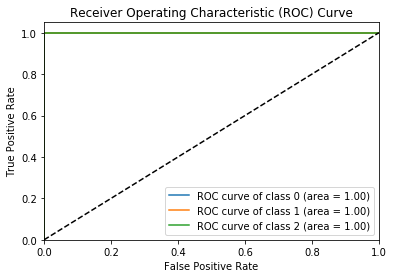

In [25]:
print("Training set metrics:\n")
y_train_pred = rf.predict(train_X)
y_train_pred_prob = rf.predict_proba(train_X)
utils.print_metrics(train_y, y_train_pred, y_train_pred_prob, 'rfc_bagofwords_only_news_train.png')

Test set metrics:

Accuracy: 0.364
Precision: 0.364
Recall: 0.364
F1 score: 0.364





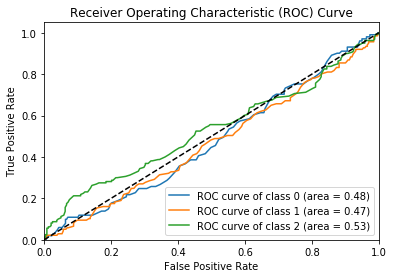

In [26]:
print("Test set metrics:\n")
y_test_pred = rf.predict(test_X)
y_test_pred_prob = rf.predict_proba(test_X)
utils.print_metrics(test_y, y_test_pred, y_test_pred_prob, 'rfc_bagofwords_only_news_test.png')

#### AdaBoost Classifier

In [0]:
adb = AdaBoostClassifier(n_estimators = 50, random_state=0).fit(X=train_X, y=train_y)

Training set metrics: 

Accuracy: 0.519
Precision: 0.519
Recall: 0.519
F1 score: 0.519





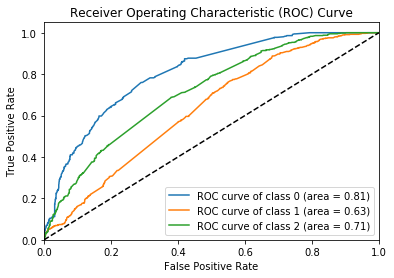

In [28]:
print("Training set metrics: \n")

y_train_pred = adb.predict(train_X)
y_train_pred_prob = adb.predict_proba(train_X)
utils.print_metrics(train_y, y_train_pred, y_train_pred_prob, 'ada_bagofwords_only_news_train.png')

Test set metrics
Accuracy: 0.364
Precision: 0.364
Recall: 0.364
F1 score: 0.364





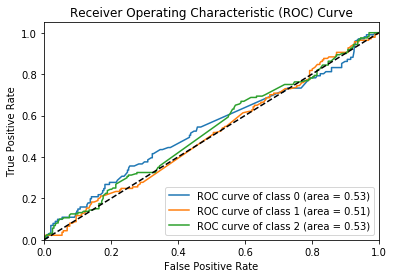

In [29]:
print("Test set metrics")

y_test_pred = adb.predict(test_X)
y_test_pred_prob = adb.predict_proba(test_X)
utils.print_metrics(test_y, y_test_pred, y_test_pred_prob, 'ada_bagofwords_only_news_test.png')

#### Neural Network

In [0]:
# Categorically encode labels
train_y_matrix = to_categorical(train_y)
test_y_matrix = to_categorical(test_y)

In [0]:
# Build neural network
model = models.Sequential()
model.add(Dense(units = 512, activation='tanh', input_shape=(train_X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units = 256, activation='tanh', input_shape=(train_X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               4096512   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

In [0]:
# Compile model
LR = .001
opt = optimizers.Adam(lr=LR)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.fit(train_X, train_y_matrix,
          batch_size=32,
          epochs=10,
          verbose=1)

Epoch 1/10
1590/1590 [==============================] - 4s 3ms/step - loss: 1.1308 - acc: 0.3830
Epoch 2/10
1590/1590 [==============================] - 3s 2ms/step - loss: 0.8224 - acc: 0.6434
Epoch 3/10
1590/1590 [==============================] - 3s 2ms/step - loss: 0.3190 - acc: 0.8862
Epoch 4/10
1590/1590 [==============================] - 3s 2ms/step - loss: 0.0666 - acc: 0.9805
Epoch 5/10
1590/1590 [==============================] - 3s 2ms/step - loss: 0.0173 - acc: 0.9956
Epoch 6/10
1590/1590 [==============================] - 3s 2ms/step - loss: 0.0049 - acc: 0.9994
Epoch 7/10
1590/1590 [==============================] - 4s 2ms/step - loss: 0.0021 - acc: 1.0000
Epoch 8/10
1590/1590 [==============================] - 4s 2ms/step - loss: 8.4467e-04 - acc: 1.0000
Epoch 9/10
1590/1590 [==============================] - 4s 2ms/step - loss: 6.0675e-04 - acc: 1.0000
Epoch 10/10
1590/1590 [==============================] - 3s 2ms/step - loss: 4.0440e-04 - acc: 1.0000


Training set metrics: 

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 score: 1.000





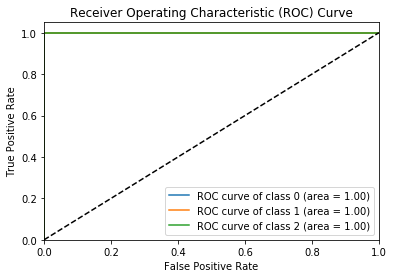

In [39]:
print("Training set metrics: \n")

y_train_pred = model.predict_classes(train_X)
y_train_pred_prob = model.predict(train_X)
utils.print_metrics(train_y, y_train_pred, y_train_pred_prob, 'nn_bagofwords_only_news_train.png')

Test set metrics
Accuracy: 0.339
Precision: 0.339
Recall: 0.339
F1 score: 0.339





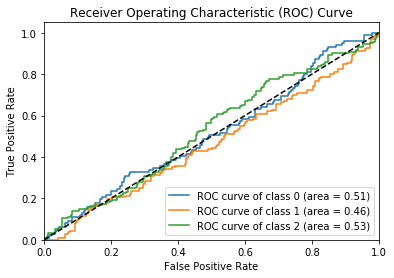

In [40]:
print("Test set metrics")

y_test_pred = model.predict_classes(test_X)
y_test_pred_prob = model.predict(test_X)
utils.print_metrics(test_y, y_test_pred, y_test_pred_prob, 'nn_bagofwords_only_news_test.png')

### Combining tokenized news and stock data

In [0]:
train_X = pd.concat([train_news_tokens_X_df, train_stock_X_df], axis=1, sort=False).values
train_y = train_stock_y_df.values

test_X = pd.concat([test_news_tokens_X_df, test_stock_X_df], axis=1, sort=False).values
test_y = test_stock_y_df.values

#### Random Forest Classifier

In [0]:
"""
Initialize a Random Forest classifier with 1000 trees .
Fit the forest to the training set, using the bag of words as 
features and the trend labels as the response variable
This may take a few minutes to run
"""
rf = RandomForestClassifier(n_estimators = 1000, random_state=0).fit(X=train_X, y=train_y)

Training set metrics:

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 score: 1.000





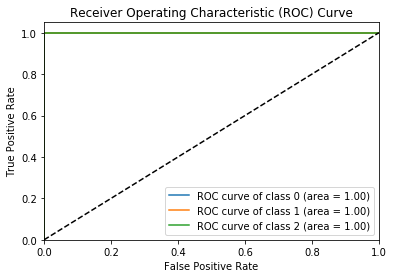

In [43]:
print("Training set metrics:\n")
y_train_pred = rf.predict(train_X)
y_train_pred_prob = rf.predict_proba(train_X)
utils.print_metrics(train_y, y_train_pred, y_train_pred_prob, 'rfc_bagofwords_news_and_stock_train')

Test set metrics:

Accuracy: 0.367
Precision: 0.367
Recall: 0.367
F1 score: 0.367





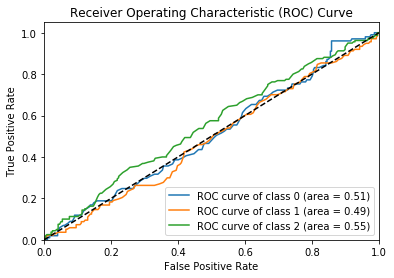

In [44]:
print("Test set metrics:\n")
y_test_pred = rf.predict(test_X)
y_test_pred_prob = rf.predict_proba(test_X)
utils.print_metrics(test_y, y_test_pred, y_test_pred_prob, 'rfc_bagofwords_news_and_stock_test')

#### AdaBoost Classifier

In [0]:
adb = AdaBoostClassifier(n_estimators = 50, random_state=0).fit(X=train_X, y=train_y)

Training set metrics: 

Accuracy: 0.517
Precision: 0.517
Recall: 0.517
F1 score: 0.517





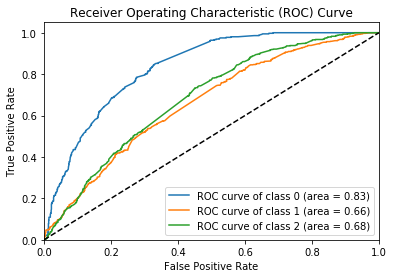

In [46]:
print("Training set metrics: \n")

y_train_pred = adb.predict(train_X)
y_train_pred_prob = adb.predict_proba(train_X)
utils.print_metrics(train_y, y_train_pred, y_train_pred_prob, 'ada_bagofwords_news_and_stock_train')

Test set metrics
Accuracy: 0.374
Precision: 0.374
Recall: 0.374
F1 score: 0.374





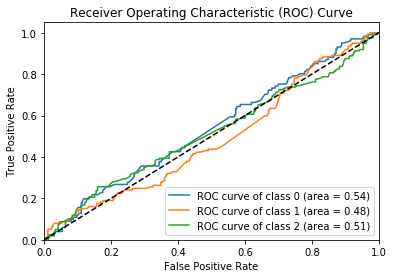

In [47]:
print("Test set metrics")

y_test_pred = adb.predict(test_X)
y_test_pred_prob = adb.predict_proba(test_X)
utils.print_metrics(test_y, y_test_pred, y_test_pred_prob, 'ada_bagofwords_news_and_stock_test')

#### Neural Network

In [0]:
# Categorically encode labels
train_y_matrix = to_categorical(train_y)
test_y_matrix = to_categorical(test_y)

In [0]:
# Build neural network
model = models.Sequential()
model.add(Dense(units = 512, activation='tanh', input_shape=(train_X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units = 256, activation='tanh', input_shape=(train_X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [0]:
# Compile model
LR = .001
opt = optimizers.Adam(lr=LR)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model.fit(train_X, train_y_matrix,
          batch_size=32,
          epochs=10,
          verbose=1)

Epoch 1/10
1590/1590 [==============================] - 7s 4ms/step - loss: 1.1371 - acc: 0.3969
Epoch 2/10
1590/1590 [==============================] - 5s 3ms/step - loss: 1.0808 - acc: 0.3962
Epoch 3/10
1590/1590 [==============================] - 5s 3ms/step - loss: 1.0817 - acc: 0.3786
Epoch 4/10
1590/1590 [==============================] - 6s 4ms/step - loss: 1.0727 - acc: 0.4019
Epoch 5/10
1590/1590 [==============================] - 6s 4ms/step - loss: 1.0746 - acc: 0.3981
Epoch 6/10
1590/1590 [==============================] - 6s 4ms/step - loss: 1.0735 - acc: 0.4063
Epoch 7/10
1590/1590 [==============================] - 6s 3ms/step - loss: 1.0751 - acc: 0.4019
Epoch 8/10
1590/1590 [==============================] - 6s 4ms/step - loss: 1.0722 - acc: 0.4038
Epoch 9/10
1590/1590 [==============================] - 6s 4ms/step - loss: 1.0755 - acc: 0.3868
Epoch 10/10
1590/1590 [==============================] - 6s 4ms/step - loss: 1.0741 - acc: 0.4069


Training set metrics: 

Accuracy: 0.409
Precision: 0.409
Recall: 0.409
F1 score: 0.409





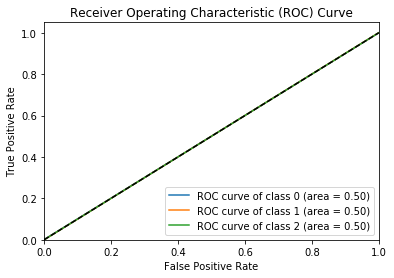

In [52]:
print("Training set metrics: \n")

y_train_pred = model.predict_classes(train_X)
y_train_pred_prob = model.predict(train_X)
utils.print_metrics(train_y, y_train_pred, y_train_pred_prob, 'rnn_bagofwords_news_and_stock_train')

Test set metrics
Accuracy: 0.344
Precision: 0.344
Recall: 0.344
F1 score: 0.344





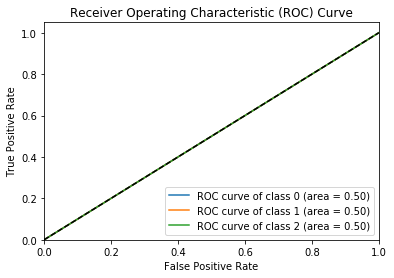

In [53]:
print("Test set metrics")

y_test_pred = model.predict_classes(test_X)
y_test_pred_prob = model.predict(test_X)
utils.print_metrics(test_y, y_test_pred, y_test_pred_prob, 'nn_bagofwords_news_and_stock_test')